# Incorporating phrases (n_grams) into a Word2Vec Model
### Steps:
1. Discovering Common Phrases in Corpora
2. Tagging Corpora with Phrases
3. Training a Word2Vec Model with the Tagged Corpora

### Notes:
* For the most part I elected to used RDD's to hold data instead of data frames. Data frames are more intuitive but RDD's usually have faster computation times.
* The data I used for this model came from a list of scotch reviews that I found online. It consists of about 2,000 records and its schema is printed below. The limited amount of data we have lends to our model performing more poorly than it would if we had more data.

# Prepwork and Setup

## Imports

In [1]:
import os
import re
import logging
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from operator import add
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Word2Vec as DfWord2Vec, StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.feature import Word2Vec

char_splitter = re.compile("[.,;!:()-]")
abspath = os.path.abspath(os.path.dirname('__file__'))
data_file = 'data/scotch_review.csv'
stop_words = set(stopwords.words())

# print full column width of pandas column's
pd.set_option('max_colwidth', -1)

logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO)

## Load and Prepare Data

In [2]:
# Load data into data frame based on defined schema. Error field catches malformed rows
schema = StructType([StructField("_c0", StringType(), True), 
                     StructField("name", StringType(), True), 
                     StructField("category", StringType(), True), 
                     StructField("review.point", IntegerType(), True), 
                     StructField("price", IntegerType(), True), 
                     StructField("currency", StringType(), True), 
                     StructField("description", StringType(), True),
                     StructField("ErrorField", StringType(), True)])

data_df = \
    (sqlContext.read
        .option('mode', 'PERMISSIVE')
        .load(os.path.join(abspath, data_file),
            format='com.databricks.spark.csv',
            header='true',
            schema=schema,
            nullValue='NA'
        )
    )

# Filter out rows that are corrupted, i.e. have the incorrect number of rows
data_df=data_df.filter(data_df.ErrorField.isNull()).drop('ErrorField').drop('currency')
data_df=data_df.na.drop(subset=['_c0'])

In [3]:
data_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- review.point: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- description: string (nullable = true)



In [4]:
data_df.toPandas().head(3)

,_c0,name,category,review.point,price,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, dried peats, elegant cigar smoke, seeds scraped from vanilla beans, brand new pencils, peppercorn, coriander seeds, and star anise make for a deeply satisfying nosing experience. Silky caramels, bountiful fruits of ripe peach, stewed apple, orange pith, and pervasive smoke with elements of burnt tobacco. An abiding finish of smoke, dry spices, and banoffee pie sweetness. Close to perfection. Editor's Choice"
1,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,"With a name inspired by a 1926 Buster Keaton movie, only 1,698 bottles produced, and the news that one of the two batches is more than 30 years old, the clues were there that this blend was never going to be cheap. It isn't, but it's superb, rich in flavor that screams dusty old oak office, fresh polish, and Sunday church, with spices, oak dried fruits, squiggly raisins, and a surprising melting fruit-and-nut dairy chocolate back story."
2,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charming, this first blended malt from Chivas Regal contains selections of five Speyside malts: Strathisla, Longmorn, Tormore, Allt-a-Bhainne, and Braeval. Red apple, cherry, raspberry fudge, peach and mango fruit salad, dusting of cinnamon, and dry heather sprigs. In essence, it’s rich and satisfying, with dark vanilla, apricot, Bourneville-covered Brazil nuts, and tangerine, smoothed over by caramel and wood spices, maltiness, and gingersnap biscuits. Quite heavenly. Editor's Choice"


In [5]:
# Create an RDD list of each description. This will form our corpus
description_rdd = data_df.select('description').rdd.flatMap(list).repartition(10)
description_rdd.take(2)

['Straw-gold color. On the nose, sweet toffee, citrus notes, seaweed, and spice complement a powerful peat smoke infusion. In body, it is thick and oily. On the palate, a somewhat sweet maltiness up front is run over by a powerful peat smoke locomotive. Again, the whisky is enriched with citrus and pear notes, spice, and seaweed. The finish is powerful, long, and warming. The smoke lingers for minutes, if not hours. If you like your Ardbeg to go to a phenolic extreme, you will cherish this one. This big, powerful whisky makes no apologies for its Islay roots. And the fact that this whisky is bottled at 46% ABV just makes this big whisky even bigger.',
 "Ardbeg's first standard release in nearly a decade, An Oa is matured in virgin oak, Pedro Ximénez, and bourbon barrels, with component whiskies married in the distillery's French oak 'Gathering Vat.' The nose offers sweet peat, smoky lemon rind, ginger, and angelica. A soft and sweet palate entry is followed by hot peat, black tea, pepp

# 1. Discovering Common Phrases in Corpora
### Steps:
1. Segment corpora into candidate phrases
2. Select candidate phrases with more than *M* occurrences in the corpora as common phrases

### Segment corpora into candidate phrases

First, remove special characters that do not indicate a phrase boundary, e.g. "\" or "%".


In [6]:
def remove_non_phrase_boundaries(text):
    """remove characters that are not indicators of phrase boundaries"""
    return re.sub("([{}@\"$%&\\\/*'’\"]|\d)", "", text)

In [7]:
description_no_special = description_rdd.map(lambda txt: remove_non_phrase_boundaries(txt))
description_no_special.first()

'Straw-gold color. On the nose, sweet toffee, citrus notes, seaweed, and spice complement a powerful peat smoke infusion. In body, it is thick and oily. On the palate, a somewhat sweet maltiness up front is run over by a powerful peat smoke locomotive. Again, the whisky is enriched with citrus and pear notes, spice, and seaweed. The finish is powerful, long, and warming. The smoke lingers for minutes, if not hours. If you like your Ardbeg to go to a phenolic extreme, you will cherish this one. This big, powerful whisky makes no apologies for its Islay roots. And the fact that this whisky is bottled at  ABV just makes this big whisky even bigger.'

Next, split text at special characters that do indicate phrase boundaries, e.g. ".", "!", or "?". Then, split phrases up further at words that indicate a phrase boundary: either stop words (e.g. "and" or "afterwards") or words that are shorter than N characters long

In [8]:
def generate_candidate_phrases(text, stopwords):
    """ generate phrases using phrase boundary markers """

    # split up into phrases at punctuation boundary markers, i.e. ".", "!", or "?"
    coarse_candidates = char_splitter.split(text.lower())

    candidate_phrases = []

    for coarse_phrase in coarse_candidates:
    
        words = re.split("\\s+", coarse_phrase)
        previous_stop = False

        # examine each word to determine if it is a phrase boundary marker or
        # part of a phrase or lone ranger
        for w in words:

            if w in stopwords and not previous_stop:
                # phrase boundary encountered, so put a hard indicator
                candidate_phrases.append(";")
                previous_stop = True
            elif w not in stopwords and len(w) > 2:
                # keep adding words to list until a phrase boundary is detected
                candidate_phrases.append(w.strip())
                previous_stop = False

    # get a list of candidate phrases without boundary demarcation
    phrases = re.split(";+", ' '.join(candidate_phrases))

    return phrases

In [9]:
# Generate candidate phrases
candidate_phrases = description_no_special.map(lambda txt: generate_candidate_phrases(txt, stop_words))
print("Example description:" + "\n" + description_no_special.first() + "\n")
print("Example candidate phrases:" + "\n" + str(candidate_phrases.first()))

Example description:
Straw-gold color. On the nose, sweet toffee, citrus notes, seaweed, and spice complement a powerful peat smoke infusion. In body, it is thick and oily. On the palate, a somewhat sweet maltiness up front is run over by a powerful peat smoke locomotive. Again, the whisky is enriched with citrus and pear notes, spice, and seaweed. The finish is powerful, long, and warming. The smoke lingers for minutes, if not hours. If you like your Ardbeg to go to a phenolic extreme, you will cherish this one. This big, powerful whisky makes no apologies for its Islay roots. And the fact that this whisky is bottled at  ABV just makes this big whisky even bigger.

Example candidate phrases:
['straw gold color ', ' nose sweet toffee citrus notes seaweed ', ' spice complement ', ' powerful peat smoke infusion ', ' body ', ' thick ', ' oily ', ' palate ', ' somewhat sweet maltiness ', ' front ', ' run ', ' powerful peat smoke locomotive ', ' ', ' whisky ', ' enriched ', ' citrus ', ' pe

### Select candidate phrases with more than *M* occurrences in the corpora as common phrases

First, perform a map and reduce operation to get a count of each phrase.

In [10]:
def phrases_to_counts(phrases):
    """ strip any white space and send back a count of 1"""
    clean_phrases = []

    for p in phrases:
        word = p.strip()

        # we only need to count phrases, so ignore unigrams
        if len(word) > 1 and ' ' in word:
            clean_phrases.append([word, 1])

    return clean_phrases

In [11]:
# Get count of candidate phrases
candidates_by_count = candidate_phrases.flatMap(lambda phrase: phrases_to_counts(phrase)) \
    .reduceByKey(add).sortBy(lambda phrases: phrases[1], ascending=False)

print("Top 3 phrases by count: " + str(candidates_by_count.take(3)))
print("Total num of phrases: " + str(candidates_by_count.count()))

Top 3 phrases by count: [('year old', 103), ('sherry casks', 44), ('chill filtered', 41)]
Total num of phrases: 21113


Next, filter out phrases that do not occur a minimum number of times in the corpora

In [12]:
# Keep phrases with more than 10 occurences
selected_phrases = candidates_by_count.filter(lambda phrases: phrases[1] >= 10) \
        .sortBy(lambda phrases: phrases[0], ascending=True)

selected_phrases.take(5)

[('age statement', 21),
 ('american oak', 10),
 ('binnys beverage depot', 16),
 ('black pepper', 40),
 ('bourbon barrels', 29)]

# 2. Tagging Corpora with Phrases
### Steps:
1. Join the words that make up a selected phrase into one entity using a "\_" character, e.g. "american oak" becomes "american_oak".
2. Create a mapping between the old phrase and the new combined phrase.
3. Replace all instances of the old phrase in the corpora with the new combined phrase.

### Join the words that make up a selected phrase into one entity and create mapping.

In [13]:
selected_phrases_tags = selected_phrases.map(lambda phrase: (phrase[0], phrase[0].replace(" ", "_")))
selected_phrases_tags.take(5)

[('age statement', 'age_statement'),
 ('american oak', 'american_oak'),
 ('binnys beverage depot', 'binnys_beverage_depot'),
 ('black pepper', 'black_pepper'),
 ('bourbon barrels', 'bourbon_barrels')]

In [14]:
selected_phrases_map = selected_phrases_tags.collectAsMap()

# broadcast a few values so that these are not copied to the worker nodes
# each time
selected_phrases_bc = sc.broadcast(selected_phrases_map)
keys = list(selected_phrases_map.keys())
keys.sort(key=len, reverse=True)
sorted_key_bc = sc.broadcast(keys)

### Replace all instances of the old phrase in the corpora with the new combined phrase.

In [15]:
def tag_data(original_text, phrase_transformation, keys):
    """Process the pipe separated file"""
    original_text = original_text.lower()

    # greedy approach, start with the longest phrase
    for phrase in keys:
        # keep track of all the substitutes for a given phrase
        original_text = original_text.replace(
            phrase, phrase_transformation[phrase])

    return original_text

def remove_punctuation(text):
    """remove all special characters"""
    return  re.sub('[^A-Za-z0-9\s]+', '', text)

In [16]:
# Tag corpus with combined phrases and remove all special characters
tagged_text_rdd = description_rdd.map(
    lambda txt: tag_data(
        remove_punctuation(txt),
        selected_phrases_bc.value, sorted_key_bc.value))

tagged_text_rdd.take(3)

['strawgold color on the nose sweet toffee citrus notes seaweed and spice complement a powerful peat_smoke infusion in body it is thick and oily on the palate a somewhat sweet maltiness up front is run over by a powerful peat_smoke locomotive again the whisky is enriched with citrus and pear notes spice and seaweed the finish is powerful long and warming the smoke lingers for minutes if not hours if you like your ardbeg to go to a phenolic extreme you will cherish this one this big powerful whisky makes no apologies for its islay roots and the fact that this whisky is bottled at 46 abv just makes this big whisky even bigger',
 'ardbegs first standard release in nearly a decade an oa is matured in virgin oak pedro ximnez and bourbon_barrels with component whiskies married in the distillerys french oak gathering vat the nose offers sweet peat smoky lemon rind ginger and angelica a soft and sweet palate entry is followed by hot peat black tea peppery cloves and aniseed black_pepper linger

# 3. Training a Phrase2Vec model using Word2Vec

In [17]:
# Learn a mapping from words to Vectors.

# split each review into a list of words
inp = tagged_text_rdd.map(lambda row: row.split(" "))

word2vec = Word2Vec().setVectorSize(3)
model = word2vec.fit(inp)

**Note:** I used PySpark's Word2Vec algorithm. The tutorial used Gensim. Should we consider this or another algorithm?

### Testing the Word2Vec Model

In [18]:
# Most occuring tagged words:
selected_phrases.sortBy(lambda phrase: phrase[1], ascending=False).take(5)

[('year old', 103),
 ('sherry casks', 44),
 ('chill filtered', 41),
 ('black pepper', 40),
 ('bourbon casks', 34)]

In [20]:
sym1 = model.findSynonyms('sherry_casks', 3)
sym2 = model.findSynonyms('chill_filtered', 3)
sym3 = model.findSynonyms('black_pepper', 3)

print("Phrases most similar to 'sherry_casks':")
print("------------------------------------")
for s in sym1: print(s)

print('\n')

print("Phrases most similar to 'chill_filtered':")
print("------------------------------------")
for s in sym2: print(s)
    
print('\n')

print("Phrases most similar to 'black_pepper':")
print("------------------------------------")
for s in sym3: print(s)

Phrases most similar to 'sherry_casks':
------------------------------------
('distilleryonly', 0.9998916983604431)
('bourbon_barrels', 0.9992993474006653)
('final', 0.9987149834632874)


Phrases most similar to 'chill_filtered':
------------------------------------
('fourth', 0.9977843761444092)
('length', 0.9967151284217834)
('center', 0.9961327910423279)


Phrases most similar to 'black_pepper':
------------------------------------
('plus', 0.9998775124549866)
('passion', 0.9998247623443604)
('prickly', 0.9990783929824829)


**Note:** Our model does not perform well because of the limited amount of data we have (~2000 records). Our text mining approach needs more data compared to a semantic chunking approach

# Categorizing Whiskey by Review Text Using a Logistic Regression Model

### Transform data to a usable format for a Regression Model.

In [22]:
# Create a dataframe with 'category' and a list of words and tagged phrases making up 'description'

data_df_2 = data_df.rdd.map(lambda x: (x['_c0'], x['category'], \
                            tag_data(remove_punctuation(x['description']), \
                                     selected_phrases_bc.value, sorted_key_bc.value).split(" ") \
                           )).toDF(['_c0', 'category', 'description'])

data_df_2.toPandas().head(3)

,_c0,category,description
0,1,Blended Scotch Whisky,"[magnificently, powerful, and, intense, caramels, dried, peats, elegant, cigar, smoke, seeds, scraped, from, vanilla, beans, brand, new, pencils, peppercorn, coriander, seeds, and, star, anise, make, for, a, deeply, satisfying, nosing, experience, silky, caramels, bountiful, fruits, of, ripe, peach, stewed, apple, orange, pith, and, pervasive, smoke, with, elements, of, burnt, tobacco, an, abiding, finish, of, smoke, dry, spices, and, banoffee, pie, sweetness, close, to, perfection, editors, choice]"
1,4,Blended Malt Scotch Whisky,"[with, a, name, inspired, by, a, 1926, buster, keaton, movie, only, 1698, bottles, produced, and, the, news, that, one, of, the, two, batches, is, more, than, 30, years_old, the, clues, were, there, that, this, blend, was, never, going, to, be, cheap, it, isnt, but, its, superb, rich, in, flavor, that, screams, dusty, old, oak, office, fresh, polish, and, sunday, church, with, spices, oak, dried, fruits, squiggly, raisins, and, a, surprising, melting, fruitandnut, dairy, chocolate, back, story]"
2,5,Blended Malt Scotch Whisky,"[captivating, enticing, and, wonderfully, charming, this, first, blended, malt, from, chivas, regal, contains, selections, of, five, speyside, malts, strathisla, longmorn, tormore, alltabhainne, and, braeval, red, apple, cherry, raspberry, fudge, peach, and, mango, fruit, salad, dusting, of, cinnamon, and, dry, heather, sprigs, in, essence, its, rich, and, satisfying, with, dark, vanilla, apricot, bournevillecovered, brazil, nuts, and, tangerine, smoothed, over, by, caramel, and, wood, spices, maltiness, and, gingersnap, biscuits, quite, heavenly, editors, choice]"


### Train a new Word2Vec Model including the category label. Output will be features for Regression Model.

In [23]:
# Train a Word2Vec Model with description and add the vectors to the data frame as features
word2Vec = DfWord2Vec(vectorSize=50, minCount=10, inputCol="description", outputCol="descriptionFeatures")
model = word2Vec.fit(data_df_2.select('description'))

data_df_2 = model.transform(data_df_2)
data_df_2.toPandas().head(1)

,_c0,category,description,descriptionFeatures
0,1,Blended Scotch Whisky,"[magnificently, powerful, and, intense, caramels, dried, peats, elegant, cigar, smoke, seeds, scraped, from, vanilla, beans, brand, new, pencils, peppercorn, coriander, seeds, and, star, anise, make, for, a, deeply, satisfying, nosing, experience, silky, caramels, bountiful, fruits, of, ripe, peach, stewed, apple, orange, pith, and, pervasive, smoke, with, elements, of, burnt, tobacco, an, abiding, finish, of, smoke, dry, spices, and, banoffee, pie, sweetness, close, to, perfection, editors, choice]","[0.01640937403620531, -0.04437112542941715, -0.06707983388927956, -0.033815577530979433, 0.06661495231233086, -0.02159928811262503, 0.014410875674167817, -0.001593708715077038, 0.026286381386770783, 0.03387806017549751, 0.018754916440229863, 0.007102825674916279, -0.042503344216101774, 0.0003255087614172336, -0.03599819493705802, 0.010388505652151776, -0.030872520673173396, -0.010217784718075894, 0.007876878519627182, 0.013570593035899838, 0.011302430593676752, -0.04975516357499697, -0.002411041184765936, 0.028717278578727874, 0.05216784041223229, 0.022604905834393296, -0.023030947170671865, 0.008439278778634176, -0.043186714936217126, 0.00045013049825546193, -0.009149618300425849, 0.028993870732268657, 0.025095979729843693, 0.01185803356665102, 0.05283013953488659, -0.023445135056549177, 0.001673991982401772, 0.025648140182690415, -0.03461033557929719, -0.004941152218221264, 0.023305269910699943, 0.035463293115643675, -0.01647484384364251, 0.08153130285526541, 0.005963018505788183, 0.06251834296607271, 0.018993016790993737, -0.02484105535514766, 0.015393289480760524, -0.004499335268822809]"


### Map Category labels to numerical indices. This is required for the Regression Model.

In [28]:
# Convert the 'category' variables to corresponding indices
stringIndexer = StringIndexer(inputCol='category', outputCol='categoryIndex')
indexed = stringIndexer.fit(data_df_2).transform(data_df_2)

indexed.select(['category','categoryIndex']).distinct().toPandas().head()

,category,categoryIndex
0,Blended Scotch Whisky,1.0
1,Grain Scotch Whisky,4.0
2,Single Malt Scotch,0.0
3,Blended Malt Scotch Whisky,2.0
4,Single Grain Whisky,3.0


### Train Logistic Regression Model and make predictions.

In [29]:
### Randomly split data into training and test sets. set seed for reproducibility
trainingData, testData = indexed.randomSplit([0.75, 0.35], seed=100)

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="categoryIndex", featuresCol="descriptionFeatures", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [30]:
# Predict category labels for the test data
predictions = lrModel.transform(testData)

# Compute raw scores on the test set
predictionAndLabels = predictions.select(['prediction', 'categoryIndex']).rdd

### Evaluate model performance

In [52]:
def plot_confusion_matrix(cm, classes, category_map, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if 'd' else '0'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Model Accuracy:  73.68%


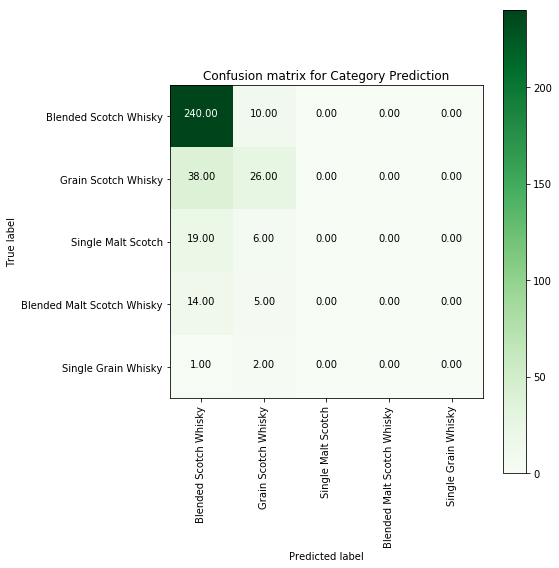

In [59]:
# get metrics for our logistic regression model
metrics = MulticlassMetrics(predictionAndLabels)

cm = metrics.confusionMatrix().toArray()

# map categories to category indices
category_map = indexed.select(['category','categoryIndex']).distinct().toPandas()
category_map = pd.Series(category_map.categoryIndex.values, index=category_map.category).to_dict()

# plot the confusion matrix and show model accuracy
plt.figure(figsize=(8,8))

plot_confusion_matrix(cm, classes=list(category_map.keys()), category_map=category_map, title='Confusion matrix for Category Prediction')

print("Model Accuracy: " + "{0: .2%}".format(metrics.accuracy))

plt.show()